In [ ]:
!pip install -q yfinance #quiet mode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 65.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-08-12,186.850006,187.589996,184.460007,185.369995,184.989853,10930900
1,2019-08-13,185.520004,191.380005,185.369995,188.449997,188.063538,13577000
2,2019-08-14,185.800003,185.990005,179.309998,179.710007,179.341476,18903700
3,2019-08-15,180.949997,183.199997,180.029999,182.589996,182.215561,12925900
4,2019-08-16,183.750000,185.100006,182.360001,183.699997,183.323273,12654600
...,...,...,...,...,...,...,...
1254,2024-08-06,479.000000,502.559998,478.649994,494.089996,494.089996,20955000
1255,2024-08-07,503.130005,510.149994,486.859985,488.920013,488.920013,20105300
1256,2024-08-08,497.500000,509.959991,494.720001,509.630005,509.630005,16156800
1257,2024-08-09,507.709991,518.340027,505.700012,517.770020,517.770020,13683700


<Axes: >

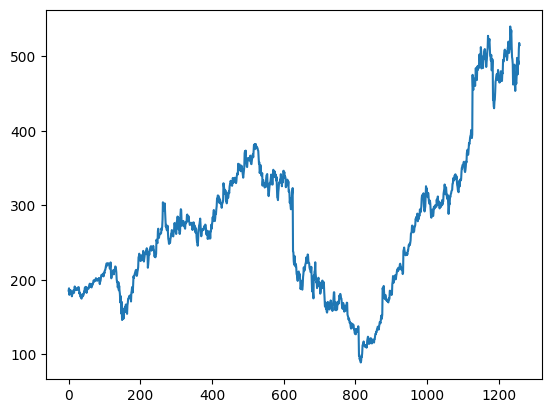

In [ ]:
df = yf.download(
    "META",
    period = "5y",
    progress = False
)

df.reset_index(inplace = True)
display(df)

df.Close.plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.regularizers import l2

In [ ]:
data = df[['Close']].values

# Norm|alizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


training_size = int(len(scaled_data) * 0.8)

# Split the data into training and testing sets
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size - 60:]


In [ ]:
def create_dataset(dataset, time_step = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_step - 1):
        x = dataset[i: (i + time_step), 0]
        data_X.append(x)
        y = dataset[i + time_step, 0]
        data_Y.append(y)

    return np.array(data_X), np.array(data_Y)

In [ ]:
TIME_STEPS = 60
X_train, Y_train = create_dataset(train_data, TIME_STEPS)
X_test, Y_test = create_dataset(test_data, TIME_STEPS)

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(946, 60, 1) (946, 1)
(251, 60, 1) (251, 1)


In [ ]:
model = Sequential()
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),

    LSTM(units=128, return_sequences=True),
    Dropout(0.5),

    LSTM(units=64, return_sequences=True),
    Dropout(0.5),

    LSTM(units=32,),
    Dropout(0.5),

    Dense(units=16),
    Dense(units=1)
])
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer, loss='mean_squared_error')

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 60, 128)           66560     
                                                                 
 dropout_16 (Dropout)        (None, 60, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 60, 64)            49408     
                                                                 
 dropout_17 (Dropout)        (None, 60, 64)            0         
                                                                 
 lstm_18 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)              

In [ ]:
model.fit(X_train, Y_train, epochs=20)

Epoch 1/25
30/30 [==============================] - 7s 98ms/step - loss: 0.0199
Epoch 2/25
30/30 [==============================] - 3s 91ms/step - loss: 0.0083
Epoch 3/25
30/30 [==============================] - 3s 91ms/step - loss: 0.0056
Epoch 4/25
30/30 [==============================] - 3s 87ms/step - loss: 0.0040
Epoch 5/25
30/30 [==============================] - 3s 92ms/step - loss: 0.0035
Epoch 6/25
30/30 [==============================] - 3s 89ms/step - loss: 0.0030
Epoch 7/25
30/30 [==============================] - 3s 89ms/step - loss: 0.0027
Epoch 8/25
30/30 [==============================] - 3s 87ms/step - loss: 0.0026
Epoch 9/25
30/30 [==============================] - 3s 89ms/step - loss: 0.0025
Epoch 10/25
30/30 [==============================] - 3s 94ms/step - loss: 0.0022
Epoch 11/25
30/30 [==============================] - 3s 88ms/step - loss: 0.0023
Epoch 12/25
30/30 [==============================] - 3s 90ms/step - loss: 0.0022
Epoch 13/25
30/30 [==================

In [ ]:
X_test.shape

(251, 60, 1)

8/8 [==============================] - 0s 31ms/step


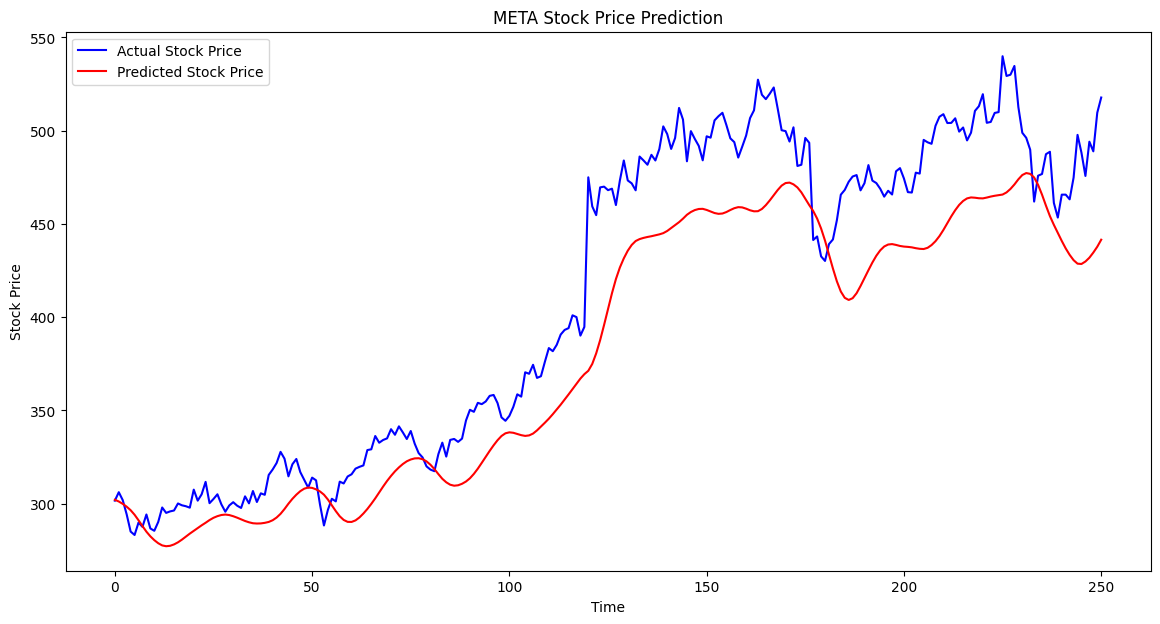

In [ ]:
predicted_prices = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted_prices)

real_prices = scaler.inverse_transform(Y_test)

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(real_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('META Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
predicted_prices.shape


(251, 1)

(946, 1) (251, 1)


<ipython-input-97-0cfd93ddbc2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predicted_prices


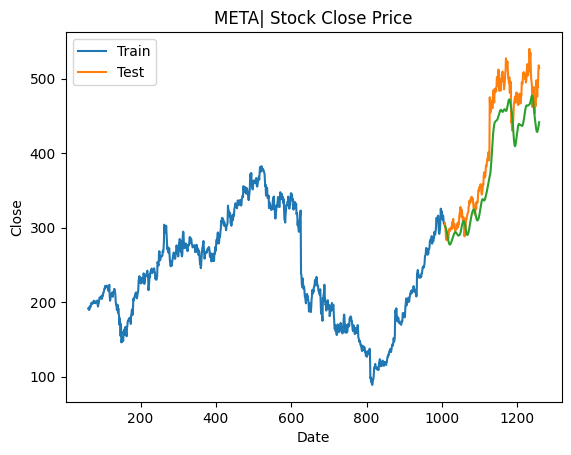

In [ ]:
plot_data = df.filter(['Close']) # df['Close] wasnt working
train = plot_data[TIME_STEPS+1:training_size]
test = plot_data[training_size+1:]
print(train.shape,test.shape)
test['Predictions'] = predicted_prices
test
plt.figure(figsize=(14, 7))
plt.plot(train)
plt.plot(test)
plt.title('META Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test'])

KeyError: 'Close'

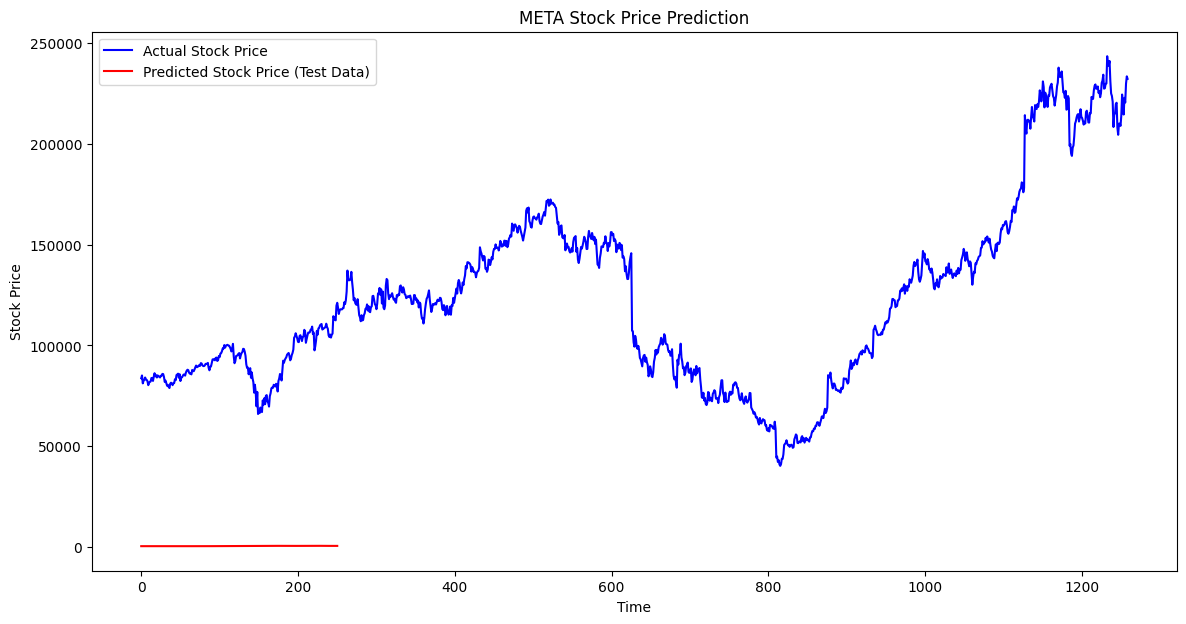

In [ ]:
a

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices